<a href="https://colab.research.google.com/github/leshcsr/IA_imageRecognition/blob/main/IA_Pokemon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Conexión con google drive para acceder al dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/MyDrive/"
!ls

/content/drive/MyDrive
'Actividad 15. Etnografía virtual.gdoc'  'FINAL MIGRACIÓN'
'Colab Notebooks'			  paragraphs
 Dataset				  texts
'Documento sin título.gdoc'		  training_history.pkl
 exportedModels


Importar las librerías necesarias

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Softmax, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint

# Preprocesamiento

In [ ]:
base_dir = 'Dataset'
train_dir = os.path.join(base_dir,'train')
test_dir = os.path.join(base_dir, 'test')
validation_dir = os.path.join(base_dir, 'validation')

train_datagen = ImageDataGenerator(
							rescale = 1./255,
							rotation_range = 10,
							width_shift_range = 0.2,
						#	height_shift_range = 0.2,
						#	shear_range = 0.3,
							zoom_range = 0.3,
							horizontal_flip = True)

Reescalado restante

In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
batch_size = 8
img_size = (150, 150)

In [ ]:
train_generator = train_datagen.flow_from_directory(
							train_dir,
							target_size = img_size,
							batch_size = batch_size,
							class_mode ='categorical',
							)

test_generator = test_datagen.flow_from_directory(
              test_dir,
              target_size=img_size,
              batch_size=batch_size,
              class_mode='categorical',
              )

Found 2584 images belonging to 8 classes.
Found 0 images belonging to 0 classes.
Found 648 images belonging to 8 classes.


<Figure size 640x480 with 0 Axes>

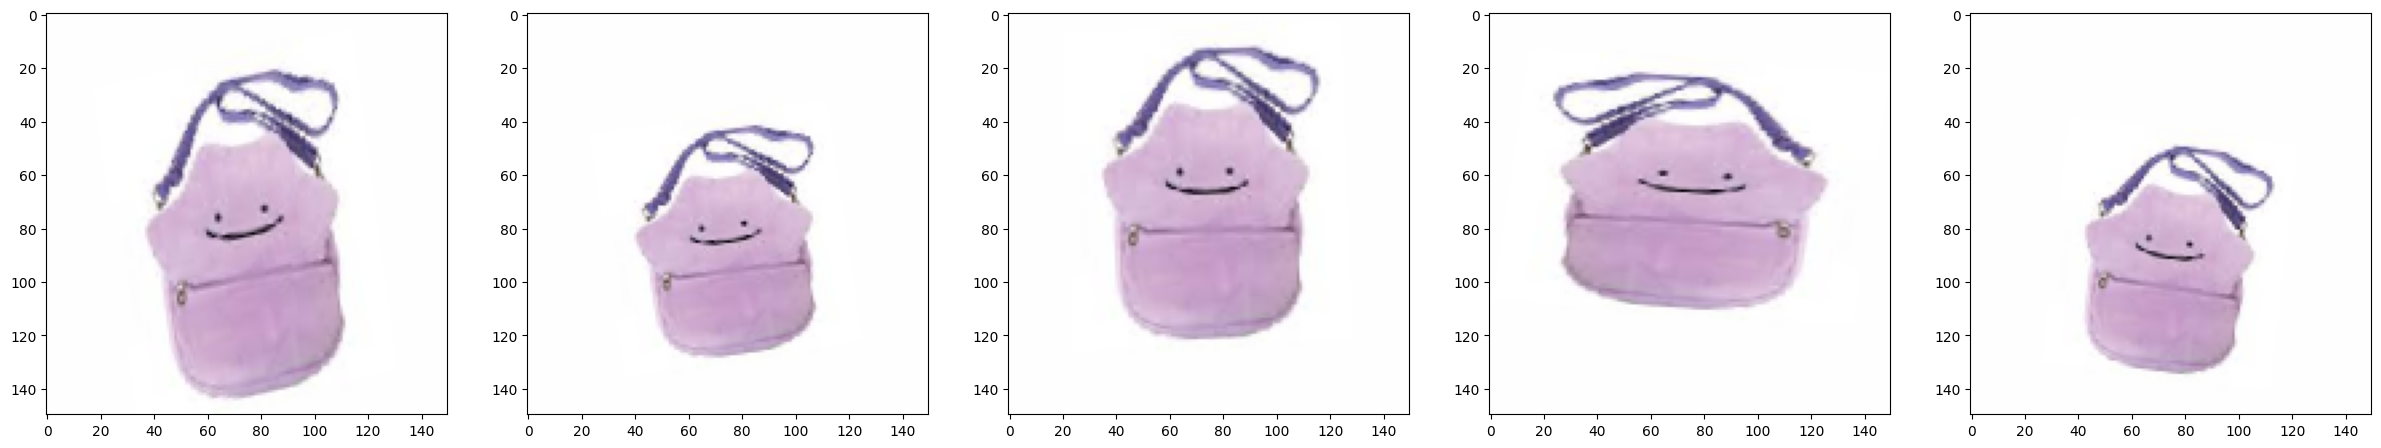

In [ ]:
plt.figure()
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, 5, figsize=(30, 8))

for i in range(5) :
  axarr[i].imshow(train_generator[0][0][0])

In [ ]:
print(train_generator.class_indices)

{'Abra': 0, 'Aerodactyl': 1, 'Arbok': 2, 'Articuno': 3, 'Bulbasaur': 4, 'Cubone': 5, 'Diglett': 6, 'Ditto': 7}


In [ ]:
model = Sequential([
    Conv2D(10, (3,3), activation='relu', input_shape=(150, 150, 3)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(8, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer=   'adam',
              loss=   "categorical_crossentropy",
              metrics =  ['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 148, 148, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 219040)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │    56,074,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,108,704 (214.04 MB)

 Trainable params: 56,108,704 (214.04 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
# Create Tensorflow checkpoint object
# Add your own path in your drive mounted folder

current_directory = "/content/drive/MyDrive"
checkpoint_path = current_directory + "/checkpoint.weights.h5"
checkpoint = ModelCheckpoint(filepath = checkpoint_path,
                             save_freq = "epoch",
                             save_weights_only = True,
                             verbose = 1)

In [49]:
history = model.fit(
						train_generator,
						epochs = 4,
						callbacks = [checkpoint])

Epoch 1/4
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6183 - loss: 1.1568
Epoch 1: saving model to /content/drive/MyDrive/checkpoint.weights.h5
323/323 ━━━━━━━━━━━━━━━━━━━━ 429s 1s/step - accuracy: 0.6184 - loss: 1.1568
Epoch 2/4
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6438 - loss: 1.0797
Epoch 2: saving model to /content/drive/MyDrive/checkpoint.weights.h5
323/323 ━━━━━━━━━━━━━━━━━━━━ 418s 1s/step - accuracy: 0.6438 - loss: 1.0797
Epoch 3/4
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6471 - loss: 1.0808
Epoch 3: saving model to /content/drive/MyDrive/checkpoint.weights.h5
323/323 ━━━━━━━━━━━━━━━━━━━━ 412s 1s/step - accuracy: 0.6472 - loss: 1.0806
Epoch 4/4
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6556 - loss: 1.0577
Epoch 4: saving model to /content/drive/MyDrive/checkpoint.weights.h5
323/323 ━━━━━━━━━━━━━━━━━━━━ 405s 1s/step - accuracy: 0.6556 - loss: 1.0577


In [50]:
test_loss, test_acc = model.evaluate(test_generator)

print('\nTest accuracy:', test_acc)

81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.7170 - loss: 0.8931

Test accuracy: 0.7145061492919922


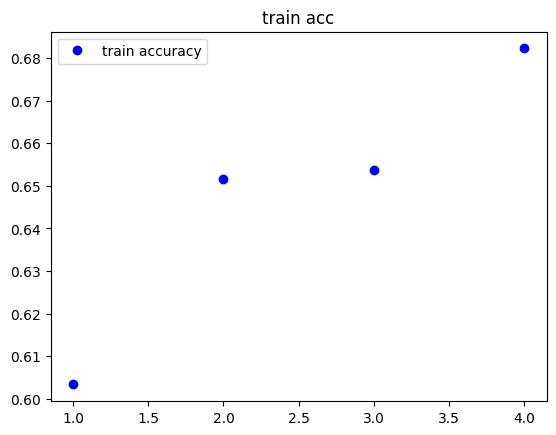

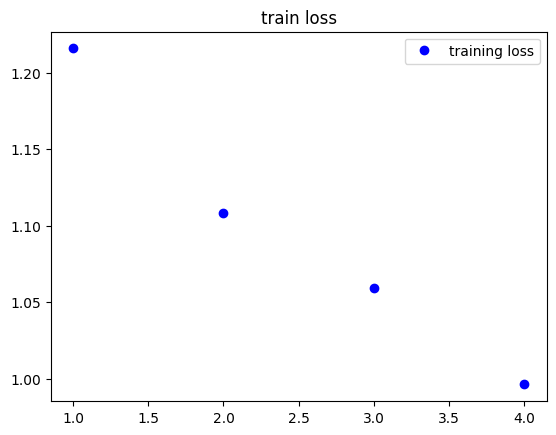

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs,acc,'bo',label='train accuracy')
plt.title('train acc')
plt.legend()

plt.figure()

plt.plot(epochs,loss, 'bo', label ='training loss')
plt.title('train loss')
plt.legend()

plt.show()

In [ ]:
test_datagen = ImageDataGenerator(1./255)
test_generator = test_datagen.flow_from_directory(
					test_dir,
					target_size = (150, 150),
					batch_size = 20,
					class_mode= 'categorical')

test_loss, test_acc = model.evaluate(test_generator, steps = 25)
print('\ntest acc :\n', test_acc)


Found 648 images belonging to 8 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 208ms/step - accuracy: 0.6428 - loss: 201.3797

test acc :
 0.6420000195503235


In [ ]:
model.save('exportedModels/modelCNN.h5')

In [ ]:
import pickle
with open('/content/drive/MyDrive/training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)